In [1]:
from airsenal.framework.utils import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
min_minutes = 90
min_matches = 10
gameweek = 3
season = "2021"


Text(0.5, 0, 'Save points')

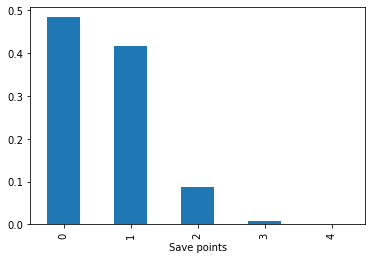

In [3]:
goalkeepers = list_players(position="GK", gameweek=gameweek, season=season)
goalkeepers = [gk.player_id for gk in goalkeepers]

query = (
    session.query(PlayerScore)
    .join(Player)
    .filter(Player.player_id.in_(goalkeepers))
    .filter(PlayerScore.minutes >= min_minutes)
)
# TODO filter on gw and season
df = pd.read_sql(query.statement, engine)

# 1pt per 3 saves
df["save_pts"] = (df["saves"] / 3).astype(int)


df["save_pts"].value_counts(normalize=True, sort=False).plot.bar()
plt.xlabel("Save points")

<AxesSubplot:xlabel='saves', ylabel='Probability'>

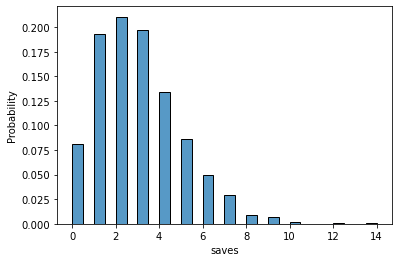

In [4]:
sns.histplot(df["saves"], stat="probability")

In [5]:
def fit_save_points(gameweek, season, min_matches=10, min_minutes=90):
    goalkeepers = list_players(position="GK", gameweek=gameweek, season=season)
    goalkeepers = [gk.player_id for gk in goalkeepers]

    query = (
        session.query(PlayerScore)
        .join(Player)
        .filter(Player.player_id.in_(goalkeepers))
        .filter(PlayerScore.minutes >= min_minutes)
    )
    # TODO filter on gw and season
    df = pd.read_sql(query.statement, engine)

    # 1pt per 3 saves
    df["save_pts"] = (df["saves"] / 3).astype(int)

    match_counts = df.groupby("player_id").save_pts.count()
    match_counts[match_counts < min_matches] = min_matches

    sum_saves = df.groupby("player_id").save_pts.sum()

    avg_saves = sum_saves / match_counts
    return avg_saves


def get_save_points(player_id, minutes, df_saves):
    if minutes >= 60:
        if player_id in df_saves.index:
            return df_saves.loc[player_id].iloc[0]
        else:
            return 0
    else:
        return 0

In [6]:
avg_saves = fit_save_points(gameweek,  season, min_matches, min_minutes)

In [7]:
players = pd.read_sql(session.query(Player).statement, engine)
players.set_index("player_id", inplace=True)

avg_saves = pd.merge(avg_saves, players, how="left", left_index=True, right_index=True)
avg_saves.sort_values(by="save_pts", ascending=False)

,save_pts,name
player_id,,
325,0.916667,Karl Darlow
433,0.900000,Roberto Jimenez Gago
431,0.891089,Lukasz Fabianski
8,0.822581,Bernd Leno
483,0.820513,Aaron Ramsdale
523,0.809524,Fraser Forster
128,0.803571,Vicente Guaita
126,0.787234,Wayne Hennessey
393,0.761905,Paulo Gazzaniga


In [8]:
get_save_points(96, 90, avg_saves)

0.6986301369863014